# Clustering de perfiles de OkCupid
Este notebook muestra el proceso de análisis, preprocesamiento y entrenamiento de modelos para agrupar perfiles similares de la web de citas OkCupid.

## 1. Setup

Librerías importadas en el proyecto.

In [85]:
import numpy as np
import pandas as pd

import os
from collections import namedtuple

from IPython.display import IFrame

try:
    from geopy.geocoders import Nominatim
except ModuleNotFoundError:
    %pip install geopy
    from geopy.geocoders import Nominatim
    
try:
    import geopandas as gpd
    import shapely
except ModuleNotFoundError:
    %pip install geopandas
    %pip install descartes
    import geopandas as gpd
    import shapely

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable
import seaborn as sns
sns.set_style("darkgrid")

Variables globales declaradas en el proyecto.

In [2]:
RANDOM_SEED = 1337
np.random.seed(RANDOM_SEED)

#!git clone https://github.com/dietrujillo/ml_lab.git ./ml_lab
# os.path.join(os.curdir, "ml_lab", "lab3", "data")  # Path to csv data
DATA_PATH = os.path.join(os.pardir, "data")
# os.path.join(os.curdir, "ml_lab", "lab3", "info")  # Path to problem info
INFO_PATH = os.path.join(os.pardir, "info")
# os.path.join(os.curdir, "ml_lab", "lab3", "results")  # Path to results files
RESULTS_PATH = os.path.join(os.pardir, "results")

Enunciado del problema.

In [3]:
# Jupyter Notebook only
IFrame(os.path.join(INFO_PATH, "lab3.pdf"), width=1080, height=920)

## 2. Análisis exploratorio de los datos

In [4]:
pd.set_option("display.max_columns", 50)
df = pd.read_csv(os.path.join(DATA_PATH, "okcupid_profiles.csv"))
display(df.iloc[:, :10])
display(df.iloc[:, 10:20])
display(df.iloc[:, 20:31])

,age,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity
0,22,single,m,straight,a little extra,strictly anything,socially,never,working on college/university,"asian, white"
1,35,single,m,straight,average,mostly other,often,sometimes,working on space camp,white
2,38,available,m,straight,thin,anything,socially,NaN,graduated from masters program,NaN
3,23,single,m,straight,thin,vegetarian,socially,NaN,working on college/university,white
4,29,single,m,straight,athletic,NaN,socially,never,graduated from college/university,"asian, black, other"
...,...,...,...,...,...,...,...,...,...,...
59941,59,single,f,straight,NaN,NaN,socially,never,graduated from college/university,NaN
59942,24,single,m,straight,fit,mostly anything,often,sometimes,working on college/university,"white, other"
59943,42,single,m,straight,average,mostly anything,not at all,never,graduated from masters program,asian
59944,27,single,m,straight,athletic,mostly anything,socially,often,working on college/university,"asian, black"


,height,income,job,last_online,location,offspring,pets,religion,sign,smokes
0,75.0,-1,transportation,2012-06-28-20-30,"south san francisco, california","doesn't have kids, but might want them",likes dogs and likes cats,agnosticism and very serious about it,gemini,sometimes
1,70.0,80000,hospitality / travel,2012-06-29-21-41,"oakland, california","doesn't have kids, but might want them",likes dogs and likes cats,agnosticism but not too serious about it,cancer,no
2,68.0,-1,NaN,2012-06-27-09-10,"san francisco, california",NaN,has cats,NaN,pisces but it doesn&rsquo;t matter,no
3,71.0,20000,student,2012-06-28-14-22,"berkeley, california",doesn't want kids,likes cats,NaN,pisces,no
4,66.0,-1,artistic / musical / writer,2012-06-27-21-26,"san francisco, california",NaN,likes dogs and likes cats,NaN,aquarius,no
...,...,...,...,...,...,...,...,...,...,...
59941,62.0,-1,sales / marketing / biz dev,2012-06-12-21-47,"oakland, california",has kids,has dogs,catholicism but not too serious about it,cancer and it&rsquo;s fun to think about,no
59942,72.0,-1,entertainment / media,2012-06-29-11-01,"san francisco, california",doesn't have kids,likes dogs and likes cats,agnosticism,leo but it doesn&rsquo;t matter,no
59943,71.0,100000,construction / craftsmanship,2012-06-27-23-37,"south san francisco, california",doesn't have kids,NaN,christianity but not too serious about it,sagittarius but it doesn&rsquo;t matter,no
59944,73.0,-1,medicine / health,2012-06-23-13-01,"san francisco, california","doesn't have kids, but wants them",likes dogs and likes cats,agnosticism but not too serious about it,leo and it&rsquo;s fun to think about,trying to quit


,speaks,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9
0,english,about me: i would love to think that i was so...,currently working as an international agent fo...,making people laugh. ranting about a good salt...,"the way i look. i am a six foot half asian, ha...","books: absurdistan, the republic, of mice and ...",food. water. cell phone. shelter.,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet! you are ti...
1,"english (fluently), spanish (poorly), french (...",i am a chef: this is what that means. 1. i am ...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories. my b...,NaN,NaN,i am very open and will share just about anyth...,NaN
2,"english, french, c++","i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,okay this is where the cultural matrix gets so...,movement conversation creation contemplation t...,NaN,viewing. listening. dancing. talking. drinking...,"when i was five years old, i was known as ""the...","you are bright, open, intense, silly, ironic, ..."
3,"english, german (poorly)",i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,"bataille, celine, beckett. . . lynch, jarmusch...",NaN,cats and german philosophy,NaN,NaN,you feel so inclined.
4,english,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at: http://bagsbrown....,i smile a lot and my inquisitive nature,"music: bands, rappers, musicians at the moment...",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
59941,english,"vibrant, expressive, caring optimist. i love b...",the happiest times have been when life came to...,i make an outstanding osso bucco. i am also ve...,"i am told that people notice my smile, eyes an...",i am an avid movie watcher and follow the broa...,"my family, my dog, italy, words and music!",writing my book.,"running with my dog, finishing up the work wee...",i have a dream to sing at the alconquin in nyc...,you are seeking a long term connection of shar...
59942,english (fluently),i'm nick. i never know what to write about mys...,currently finishing school for film production...,"filmmaking, photography, graphic design, web d...","dude, i don't know.","movies: hook (the greatest adventure ever!), g...",iphone contact lenses headphones camera tv rem...,i do most of my thinking on the bus to/from wo...,"bringin' home bacon, or drinking and shakin'!",when i was 18 i got a tattoo of waldo somewher...,meh if you made it this far you might as well.
59943,english (fluently),"hello! i enjoy traveling, watching movies, and...","i'm a civil engineer, who enjoys helping the c...",- looking at things objectively - getting thin...,i'm quiet until i get used to the environment ...,"last book: ""game change"". movies: bourne serie...",- iphone - friends and family - internet - bay...,"aside from work, how to improve my home.",out enjoying friendly conversation over dinner.,please let me think about this more.,we have similar interests.
59944,"english (fluently), spanish (poorly), chinese ...","""all i have in this world are my balls and my ...","following my dreams... ""you got a dream... you...",listening,it used to be the hair until i mowed it off bu...,where to begin musically: right now i listen t...,"music, family, friends, a basketball, hoop, so...",what can i do to make someone chuckle....,what i would do on any other day. everydays a ...,i like walking around in other people's house ...,you are interested and interesting...


In [5]:
df.dtypes

age              int64
status          object
sex             object
orientation     object
body_type       object
diet            object
drinks          object
drugs           object
education       object
ethnicity       object
height         float64
income           int64
job             object
last_online     object
location        object
offspring       object
pets            object
religion        object
sign            object
smokes          object
speaks          object
essay0          object
essay1          object
essay2          object
essay3          object
essay4          object
essay5          object
essay6          object
essay7          object
essay8          object
essay9          object
dtype: object

La codificación de los tipos de las variables es correcta, por lo que no será necesario hacer ninguna transformación de tipos.

 Se tienen variables numéricas y textuales. Sin embargo, observando los contenidos de algunas columnas, es evidente que no son de texto libre, y que se pueden considerar variables categóricas. Vamos a definir los diferentes tipos de características:

In [6]:
numerical_vars = ["age", "height", "income"]
categorical_vars = ["status", "sex", "orientation", "body_type", "diet", "drinks", "drugs", "education",
                    "ethnicity", "job", "location", "offspring", "pets", "religion", "sign", "smokes", "speaks"]
text_vars = [f"essay{i}" for i in range(10)]

Llegados a este punto podemos prescindir de una variable que no será de utilidad a la hora de hacer el clustering. Esta variable es `last_online`, que repesenta la fecha y hora de última conexión. Con esta decisión reducimos el volumen de datos y nos centramos en las columnas numéricas y categóricas que aportan información sobre la personalidad, preferencias o apariencia física de una persona.

In [7]:
del df["last_online"]

### 2.1 Análisis de variables numéricas

#TODO

In [8]:
df.describe()

,age,height,income
count,59946.000000,59943.000000,59946.000000
mean,32.340290,68.295281,20033.222534
std,9.452779,3.994803,97346.192104
min,18.000000,1.000000,-1.000000
25%,26.000000,66.000000,-1.000000
50%,30.000000,68.000000,-1.000000
75%,37.000000,71.000000,-1.000000
max,110.000000,95.000000,1000000.000000


En este punto ya podemos observar como hay algunos datos numéricos un tanto extraños:
* La edad máxima es 110, lo cual hace dudar que sea un dato correcto. Posiblemente esta edad corresponda con personas que no quieren compartir su edad verdadera.
* La altura parece estar en pulgadas, *inches*, la media es 68 que se corresponde con 172 cm aprox. En este sentido vemos que la altura mínima es 1 pulgada y que la máxima es de 95 (241 cm). Según la lista de personas más altas del mundo publicada en Wikipedia [1], una altura de entorno a 90 pulgadas(230 cm) ya es algo inaudito.
* Los ingresos llaman la atención en tanto que el ingreso mínimo es -1 y el percentil 75 también es -1. Esto indica que al menos el 75% de los usuarios de la aplicación no han querido decir sus ingresos.

#### 2.2.1 Análisis de la altura

In [9]:
df[df["height"] > 90]["height"]

402      91.0
2569     95.0
3016     95.0
8089     95.0
12181    93.0
17949    95.0
22358    95.0
23760    94.0
25324    95.0
27506    91.0
33640    95.0
33885    95.0
33946    95.0
34607    95.0
34672    94.0
41939    95.0
43452    95.0
44096    95.0
44264    91.0
47621    92.0
48304    95.0
49194    95.0
51714    95.0
53469    95.0
55172    95.0
56931    95.0
57978    95.0
58147    94.0
Name: height, dtype: float64

#### 2.2.2 Análisis de la edad

In [10]:
df[df["age"] > 80]

,age,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,height,income,job,location,offspring,pets,religion,sign,smokes,speaks,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9
2512,110,single,f,straight,NaN,NaN,NaN,NaN,NaN,NaN,67.0,-1,NaN,"daly city, california",NaN,NaN,NaN,NaN,NaN,english,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25324,109,available,m,straight,athletic,mostly other,NaN,never,working on masters program,NaN,95.0,-1,student,"san francisco, california",might want kids,NaN,other and somewhat serious about it,aquarius but it doesn&rsquo;t matter,when drinking,english (okay),NaN,NaN,NaN,nothing,NaN,NaN,NaN,NaN,NaN,NaN


#### 2.2.3 Análisis de los ingresos

In [11]:
(len(df[df["income"] < 0]) / len(df)) * 100

80.80939512227671

### 2.2 Análisis de las variables categóricas

#### 2.2.1 Análisis del estado marital

El estado marital debería ser una variable categórica simple. Vamos a ver qué posibles valores hay.

In [12]:
df["status"].value_counts(dropna=False)

single            55697
seeing someone     2064
available          1865
married             310
unknown              10
Name: status, dtype: int64

Estos posibles estados parecen ser compatibles entre sí. Asumimos que el estado `unknown` significa que el usuario ha preferido no decirlo, no que sea un tipo diferente. Por eso, podremos codificar esta variable como un `one-hot` haciendo que el valor `unknown` sea un vector completo de ceros. Si hubiera valores `nan`, se considerarían igual que `unknown`.

Parece que no hay valores nulos.

#### 2.2.2 Análisis del sexo

In [13]:
df["sex"].value_counts(dropna=False)

m    35829
f    24117
Name: sex, dtype: int64

En este caso parece una variable binaria clara. Parece que hay una predominancia de hombres en la aplicación.

#### 2.2.3 Análisis de la orientación sexual

In [14]:
df["orientation"].value_counts(dropna=False)

straight    51606
gay          5573
bisexual     2767
Name: orientation, dtype: int64

La variable `orientation` tiene tres posibles valores. Sin embargo, en lugar de clasificar como un vector `one-hot`, creemos que a efectos de agrupar perfiles similares, podemos convertir esta variable en dos columnas binarias nuevas, `likes_men` y `likes_women`. Nos basamos en la idea de que el tipo `straight` no significa lo mismo si la persona en cuestión es hombre que si es mujer. Un clustering funcionará mejor si realizamos esta conversión.

#### 2.2.4 Análisis de la complexión corporal

In [15]:
df["body_type"].value_counts(dropna=False)

average           14652
fit               12711
athletic          11819
NaN                5296
thin               4711
curvy              3924
a little extra     2629
skinny             1777
full figured       1009
overweight          444
jacked              421
used up             355
rather not say      198
Name: body_type, dtype: int64

Hay muchos de estos tipos que podemos agrupar desde el principio. Por ejemplo, `fit` y `athletic`. Como perspectiva alternativa, podemos convertirlo en una o varias escalas ordinales. Por ejemplo, una escala de menor a mayor peso, junto con una escala de menor a mayor proporción de grasa a masa muscular. Si seguimos esta segunda alternativa, el tipo `"rather not say"` tendrá que ser considerado `"average"`.

En cualquiera de los casos, los valores nulos se considerarán iguales a `rather not say`.

#### 2.2.5 Análisis de la dieta

In [16]:
df["diet"].value_counts(dropna=False)

NaN                    24395
mostly anything        16585
anything                6183
strictly anything       5113
mostly vegetarian       3444
mostly other            1007
strictly vegetarian      875
vegetarian               667
strictly other           452
mostly vegan             338
other                    331
strictly vegan           228
vegan                    136
mostly kosher             86
mostly halal              48
strictly kosher           18
strictly halal            18
kosher                    11
halal                     11
Name: diet, dtype: int64

Parece que en este caso tenemos tipos de dieta (`anything, vegan, kosher`) con prefijos que muestran lo estricto que son (`mostly, strictly`). Vamos a ver qué tipos hay:

In [17]:
prefixes = set()
diets = set()
for item in filter(lambda x: not pd.isnull(x), df["diet"].unique()):
    if " " in item:
        prefix, diet = tuple(item.split())
        prefixes.add(prefix)
        diets.add(diet)
    else:
        diets.add(item)
print(prefixes)
print(diets)

{'strictly', 'mostly'}
{'vegan', 'other', 'vegetarian', 'kosher', 'anything', 'halal'}


\# TODO: how to encode this information (for example: vegetarian and vegan should be close)

#### 2.2.6 Análisis de la bebida

In [18]:
df["drinks"].value_counts(dropna=False)

socially       41780
rarely          5957
often           5164
not at all      3267
NaN             2985
very often       471
desperately      322
Name: drinks, dtype: int64

Esto parece un ejemplo claro de variable ordinal. Hay demasiados valores `NaN` como para eliminarlos, pero podremos utilizar un `imputer` para completar los datos que nos faltan.

#### 2.2.7 Análisis de la toma de drogas

In [19]:
df["drugs"].value_counts(dropna=False)

never        37724
NaN          14080
sometimes     7732
often          410
Name: drugs, dtype: int64

De nuevo, esto parece ser un ejemplo de variable ordinal. Sin embargo, aquí tenemos una hipótesis que comprobaremos más adelante sobre los valores `NaN`: que los valores `NaN` deberían estar en la escala ordinal entre `never` y `sometimes`, porque son personas que han tomado drogas esporádicamente en el pasado, pero que no quieren decir `sometimes`. 

\# TODO: see if we can prove this

#### 2.2.8 Análisis de la educación recibida

In [20]:
df["education"].value_counts(dropna=False)

graduated from college/university    23959
graduated from masters program        8961
NaN                                   6628
working on college/university         5712
working on masters program            1683
graduated from two-year college       1531
graduated from high school            1428
graduated from ph.d program           1272
graduated from law school             1122
working on two-year college           1074
dropped out of college/university      995
working on ph.d program                983
college/university                     801
graduated from space camp              657
dropped out of space camp              523
graduated from med school              446
working on space camp                  445
working on law school                  269
two-year college                       222
working on med school                  212
dropped out of two-year college        191
dropped out of masters program         140
masters program                        136
dropped out

Esto parece otro ejemplo de variables con prefijos. Observando las combinaciones únicas que tenemos, podemos extraer los prefijos:

In [21]:
prefixes = ["graduated from", "working on", "dropped out of"]
educations = set()
for item in filter(lambda x: not pd.isnull(x), df["education"].unique()):
    for prefix in prefixes:
        if prefix in item:
            educations.add(item.replace(prefix, "").strip())
print(educations)

{'masters program', 'two-year college', 'high school', 'med school', 'ph.d program', 'space camp', 'college/university', 'law school'}


#### 2.2.9 Análisis de la etnia

In [22]:
df["ethnicity"].value_counts(dropna=False)

white                                                                                        32831
asian                                                                                         6134
NaN                                                                                           5680
hispanic / latin                                                                              2823
black                                                                                         2008
                                                                                             ...  
asian, middle eastern, hispanic / latin, white, other                                            1
asian, black, native american, indian                                                            1
asian, black, indian, hispanic / latin, other                                                    1
black, native american, pacific islander, hispanic / latin                                       1
middle eas

Este parece un caso en el que tenemos etnias únicas separadas por comas. Podemos extraer los valores únicos separando por las comas.

In [23]:
ethnicities = set()
for item in df["ethnicity"].unique():
    if pd.isnull(item) or not "," in item:
        ethnicities.add(item)
    else:
        for unique_value in item.split(","):
            ethnicities.add(unique_value.strip())
print(ethnicities)

{nan, 'hispanic / latin', 'middle eastern', 'other', 'indian', 'asian', 'black', 'native american', 'white', 'pacific islander'}


En este caso, podemos plantearnos codificar la etnicidad de una persona como un vector que tenga una variable por etnia y un valor que represente el porcentaje que se pertenece a dicha etnia, asumiendo igual proporción de las etnias que el usuario suministre al sistema. Por ejemplo, una persona de raza asiática tendrá un 1 en la columna de raza asiática y 0 en el resto (como al hacer un one-hot encoding), mientras que alguien biracial de etnias caucásica y africana tendrá 0.5 en estas dos categorías y 0 en el resto. Vamos a mirar cuál es el número de razas que la gente aporta al sistema en general:

In [24]:
ethnicity_counts = df["ethnicity"].apply(lambda x: x.count(",") + 1 if not pd.isnull(x) else 0)
print(f"Media: {ethnicity_counts.mean()}")
print(f"Q1: {ethnicity_counts.quantile(0.25)}")
print(f"Mediana: {ethnicity_counts.median()}")
print(f"Q3: {ethnicity_counts.quantile(0.75)}")
print(f"P95: {ethnicity_counts.quantile(0.95)}")
print(f"Moda: {ethnicity_counts.mode().iloc[0]}")
print(f"Máximo: {ethnicity_counts.max()}")

Media: 1.0588863310312615
Q1: 1.0
Mediana: 1.0
Q3: 1.0
P95: 2.0
Moda: 1
Máximo: 9


La mayoría de usuarios han dado una sola etnia. Sin embargo, algunos han llegado a dar 9. Esto nos dará problemas, porque si seguimos nuestra codificación habrá vectores en los que el valor será $\frac{1}{9}$, un valor minúsculo. Si asumimos que las razas se han proporcionado al programa en orden de prioridad, podemos quedarnos con las tres o cuatro más relevantes cogiendo las tres o cuatro primeras. Vamos a ver si es posible que se hayan proporcionado en orden de prioridad.

In [25]:
all(df["ethnicity"].apply(lambda x: x.split() == sorted(x.split()) if not pd.isnull(x) else True))

False

De aquí sacamos que el orden no es alfabético, lo cual nos indica que lo más probable es que estén ordenados por prioridad. No podemos estar seguros, pero todo indica a que este es el caso. Por eso, utilizaremos sólo las tres primeras razas que el usuario proporcione.

#### 2.2.10 Análisis de la ocupación laboral

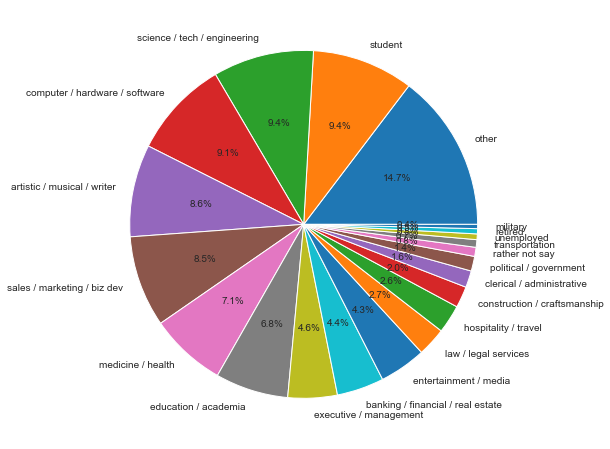

In [26]:
plt.figure(figsize=(20, 8))
plt.pie(df["job"].value_counts(), labels=df["job"].value_counts().keys(), autopct="%1.1f%%")
plt.show()

Parece que este es un caso claro de variable categórica sin más. Quizás fuera beneficioso mezclar algunos campos, como los de `science` con `academia` o `computer/hardware/software` con `tech`. Sin embargo, como los campos ya vienen mezclados, no se puede hacer una conversión así. En este caso no daremos un tratamiento especial a `other`, sino que lo consideraremos un tipo más en el one-hot.

\# TODO: justify why one-hot to other

#### 2.2.11 Análisis de la localización geográfica

In [27]:
df["location"].value_counts(dropna=False)

san francisco, california      31064
oakland, california             7214
berkeley, california            4212
san mateo, california           1331
palo alto, california           1064
                               ...  
amsterdam, netherlands             1
philadelphia, pennsylvania         1
boulder, colorado                  1
san luis obispo, california        1
fayetteville, west virginia        1
Name: location, Length: 199, dtype: int64

Lo primero es ver si hay valores nulos.

In [28]:
any(df["location"].isnull())

False

Parece que todas las localizaciones siguen la forma [ciudad], [estado]. Debemos comprobar si es el caso para todos.

In [29]:
all(df["location"].apply(lambda x: x.count(",") == 1))

False

In [30]:
df["location"][df["location"].apply(lambda x: x.count(",") != 1)]

42438    vancouver, british columbia, canada
Name: location, dtype: object

Sólo el caso de una sóla fila de un usuario de Vancouver tiene tres partes. Esto es porque Canadá tiene estados. En general, el formato [ciudad], [estado] parece cumplirse siempre, siendo [ciudad], [país] si no hablamos de Estados Unidos.

In [31]:
vancouver = df["location"][df["location"].apply(lambda x: x.count(",") != 1)]
assert len(vancouver) == 1
vancouver_id = vancouver.index[0]

df.at[vancouver_id, "location"] = "vancouver, canada"

In [32]:
all(df["location"].apply(lambda x: x.count(",") == 1))

True

Ahora que parece que todo está en el mismo formato, vamos a codificar la localización en latitud y longitud. Para ello utilizaremos la clase [`Nominatim`](https://geopy.readthedocs.io/en/stable/#nominatim) de `geopy`.

In [33]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent='myapplication')

Coordinates = namedtuple("Coordinates", ("latitude", "longitude"))

def get_coordinates(loc):
    city, state = loc.title().split(",")
    geocode = geolocator.geocode(f"{city} {state}")
    return Coordinates(geocode.latitude, geocode.longitude)
    
coordinates_dict = {}
for location in df["location"].unique():
    coordinates_dict[location] = get_coordinates(location)
    
for location in df["location"].unique()[:5]:
    print(location, coordinates_dict[location].latitude, coordinates_dict[location].longitude)

south san francisco, california 37.6535403 -122.4168664
oakland, california 37.8044557 -122.2713563
san francisco, california 37.7790262 -122.4199061
berkeley, california 37.8708393 -122.2728639
belvedere tiburon, california 37.8771208 -122.4616696


Para asegurarnos de que no hay errores, en lugar de ir comprobando los datos uno a uno podemos simplemente mostrar una imagen con las localizaciones en un mapa. Utilizamos una escala logarítmica para visualizar bien las diferencias entre puntos.

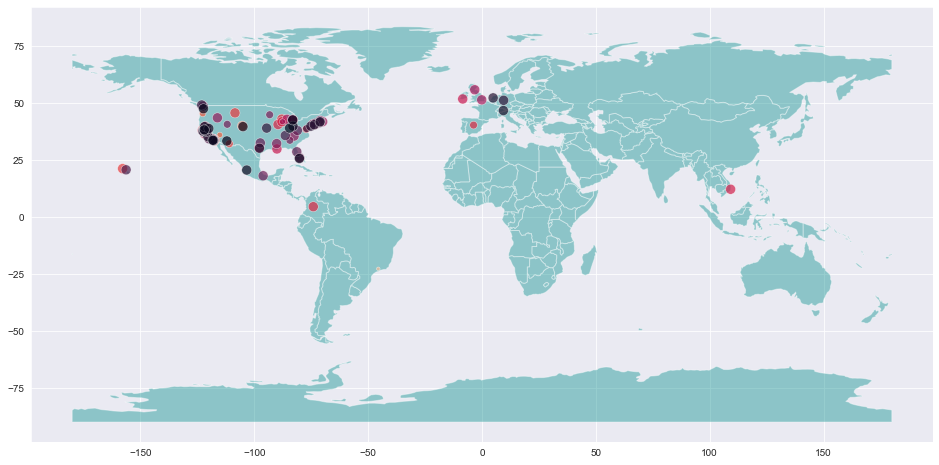

In [139]:
geometry = [shapely.geometry.Point(lon, lat) for lat, lon in coordinates_dict.values()]

locations = gpd.GeoDataFrame({"location": coordinates_dict.keys()}, geometry=geometry)
counts = df["location"].value_counts()
locations["count"] = [counts.loc[x] for x in coordinates_dict.keys()]

fig, ax = plt.subplots(figsize=(30, 8))
world.plot(ax=ax, color="darkcyan", alpha=0.4)
scale = (np.log(locations["count"]) + 1) * 50
locations.plot(ax=ax, alpha=0.7, edgecolor="white", linewidth=0.5, markersize=5000/scale, c=scale, cmap="rocket_r")
plt.show()

Ahora tenemos las coordenadas de cada persona y sabemos que la codificación es correcta. En el preprocesamiento aplicaremos la transformación al DataFrame.

### 2.3 Análisis de las variables de texto libre

## 3. Preprocesamiento

## 4. Clustering

## 5. Conclusiones

## 6. Referencias

[1] https://en.wikipedia.org/wiki/List_of_tallest_people

---
Creado por **Diego Trujillo** (diego.trujillo.jimenez@alumnos.upm.es) y **Ángel Acevedo** (angel.acevedo.sanchez@alumnos.upm.es) 

<br></br>
[![License: GPL v2](https://img.shields.io/badge/License-GPL%20v2-blue.svg)](https://www.gnu.org/licenses/old-licenses/gpl-2.0.en.html)